In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def show_img(img, figsize=None, gray=True):
    if figsize is not None:
        fig=plt.figure(figsize=figsize)
    if gray:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(img)

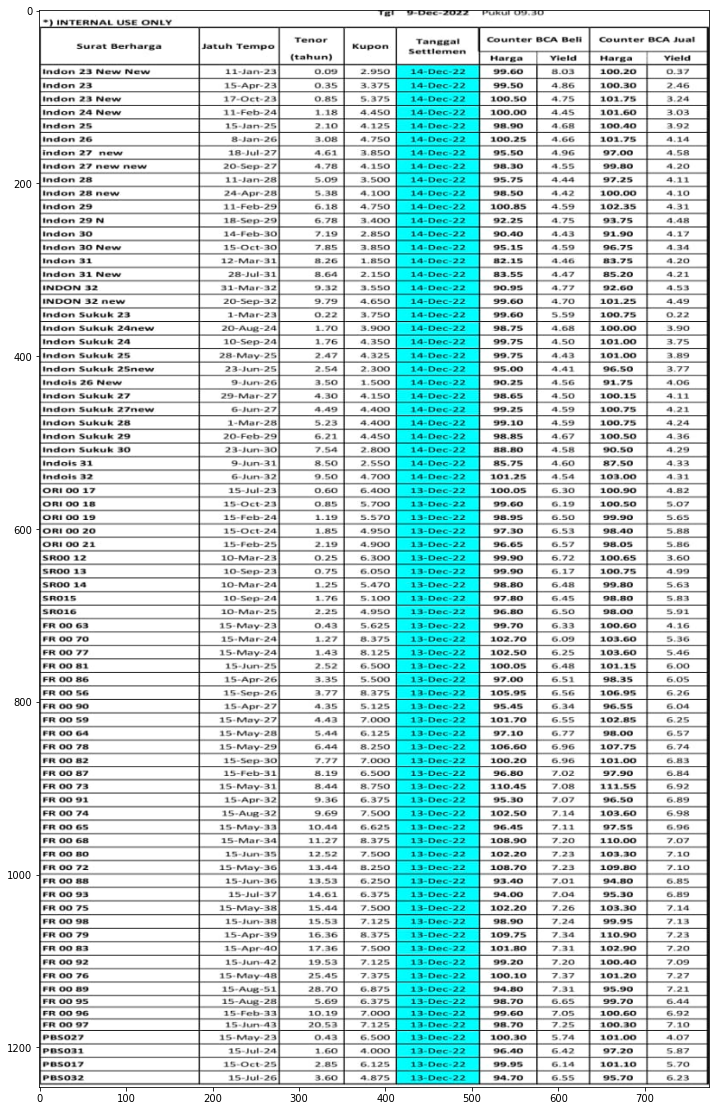

In [34]:
# This function was taken from Eric Ihli's project: https://github.com/eihli/image-table-ocr

def find_tables(image):
    image_ori = np.copy(image)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
#     show_img(img)
    BLUR_KERNEL_SIZE = (11, 11)
    STD_DEV_X_DIRECTION = 0
    STD_DEV_Y_DIRECTION = 0
    blurred = cv.GaussianBlur(image, BLUR_KERNEL_SIZE, STD_DEV_X_DIRECTION, STD_DEV_Y_DIRECTION)
#     show_img(blurred, figsize=(12,20), gray=True)
    
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2
    
    img_bin = cv.adaptiveThreshold(
        ~blurred,
        MAX_COLOR_VAL,
        cv.ADAPTIVE_THRESH_MEAN_C,
        cv.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )
#     show_img(img_bin, figsize=(12,20))
    
    vertical = horizontal = img_bin.copy()
    SCALE = 5
    image_width, image_height = horizontal.shape
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(image_width / SCALE), 1))
    horizontally_opened = cv.morphologyEx(img_bin, cv.MORPH_OPEN, horizontal_kernel)
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(image_height / SCALE)))
    vertically_opened = cv.morphologyEx(img_bin, cv.MORPH_OPEN, vertical_kernel)
    
#     show_img(horizontally_opened, figsize=(12,20))
#     show_img(vertically_opened, figsize=(12,20))
    
    horizontally_dilated = cv.dilate(horizontally_opened, cv.getStructuringElement(cv.MORPH_RECT, (40, 1)))
    vertically_dilated = cv.dilate(vertically_opened, cv.getStructuringElement(cv.MORPH_RECT, (1, 40)))
    
    mask = horizontally_dilated + vertically_dilated
#     show_img(mask, figsize=(12,20))
    
    contours, heirarchy = cv.findContours(
        mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE,
    )
    MIN_TABLE_AREA = 1e5
    contours = [c for c in contours if cv.contourArea(c) > MIN_TABLE_AREA]
    perimeter_lengths = [cv.arcLength(c, True) for c in contours]
    epsilons = [0.1 * p for p in perimeter_lengths]
    approx_polys = [cv.approxPolyDP(c, e, True) for c, e in zip(contours, epsilons)]
    bounding_rects = [cv.boundingRect(a) for a in approx_polys]

    # The link where a lot of this code was borrowed from recommends an
    # additional step to check the number of "joints" inside this bounding rectangle.
    # A table should have a lot of intersections. We might have a rectangular image
    # here though which would only have 4 intersections, 1 at each corner.
    # Leaving that step as a future TODO if it is ever necessary.
    images = [image_ori[y:y+h, x:x+w] for x, y, w, h in bounding_rects]
    return images

# Test
filename = "../test3.jpeg"
img = cv.imread(filename)
tables = find_tables(img)

for table in tables:
    show_img(table, figsize=(12,20), gray=False)

<Figure size 864x2880 with 0 Axes>

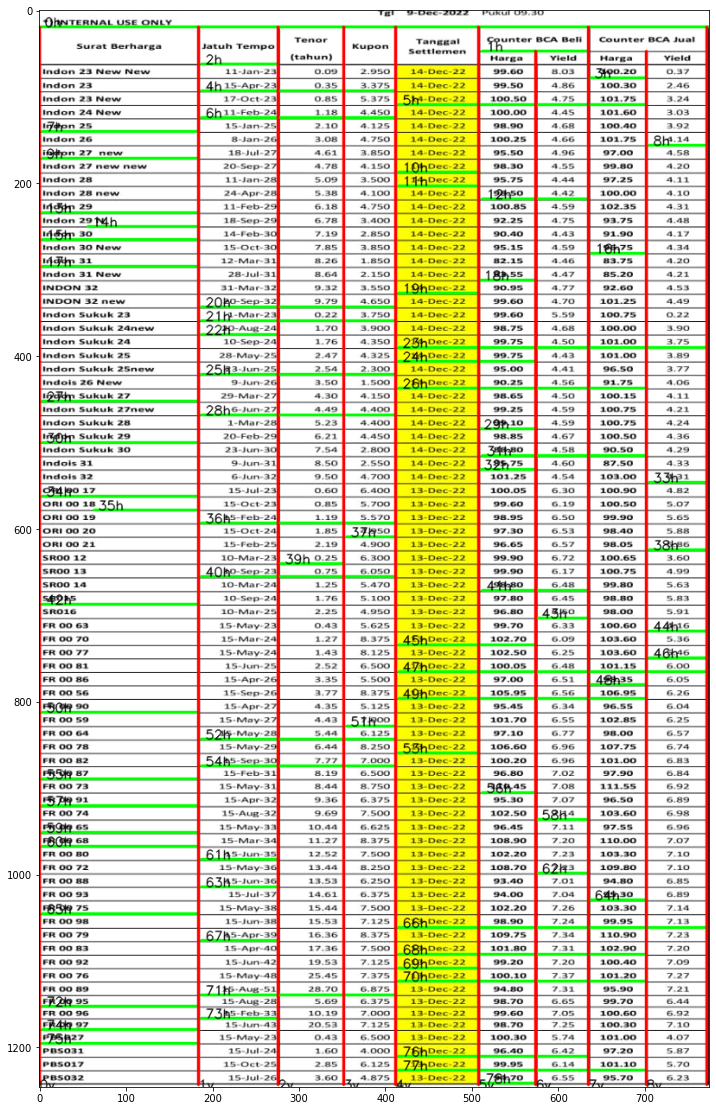

In [77]:
# The method and code were learned/taken from this excellent article by Fazlur Rahman:
# https://levelup.gitconnected.com/text-extraction-from-a-table-image-using-pytesseract-and-opencv-3342870691ae

def is_vertical(line):
    return line[0]==line[2]

def is_horizontal(line):
    return line[1]==line[3]

def find_lines(canny, img_copy=None, rho=1, threshold=50, min_line_length=350, max_line_gap=6,
               func_h=None, func_v=None):
    theta = np.pi/180
    linesP = cv.HoughLinesP(canny, rho , theta, threshold, None, min_line_length, max_line_gap)

    horizontal_lines = []
    vertical_lines = []
    lines = []

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            if (is_vertical(l)): 
                vertical_lines.append(l)

            elif (is_horizontal(l)):
                horizontal_lines.append(l)
            
            lines.append(l)
        if func_h is not None:
            horizontal_lines = func_h(horizontal_lines)
        if func_v is not None:
            vertical_lines = func_v(vertical_lines)
#         horizontal_lines = overlapping_filter(horizontal_lines, 1, separation=separation)
#         vertical_lines = overlapping_filter(vertical_lines, 0, separation=separation)
    
    img_show = None
    if img_copy is not None:
        for i, line in enumerate(horizontal_lines):
            cv.line(img_copy, (line[0], line[1]), (line[2], line[3]), (0,255,0), 2, cv.LINE_AA)
            cv.putText(img_copy, str(i) + "h", (line[0] + 5, line[1]), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv.LINE_AA)                      
        for i, line in enumerate(vertical_lines):
            cv.line(img_copy, (line[0], line[1]), (line[2], line[3]), (0,0,255), 2, cv.LINE_AA)
            cv.putText(img_copy, str(i) + "v", (line[0], line[1] + 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv.LINE_AA)

#         for i, line in enumerate(lines):
#             cv.line(img_copy, (line[0], line[1]), (line[2], line[3]), (0,255,0), 2, cv.LINE_AA)

        img_show = img_copy[:,:,::-1]
    return [horizontal_lines, vertical_lines, img_show]
    
    
def overlapping_filter(lines, sorting_index, separation=5):
    filtered_lines = []
    
    lines = sorted(lines, key=lambda lines: lines[sorting_index])
    for i in range(len(lines)):
            l_curr = lines[i]
            if(i>0):
                l_prev = lines[i-1]
                if ( (l_curr[sorting_index] - l_prev[sorting_index]) > separation):
                    filtered_lines.append(l_curr)
            else:
                filtered_lines.append(l_curr)
                
    return filtered_lines

def get_cropped_image(image, x, y, w, h):
    cropped_image = image[ y:y+h , x:x+w ]
    return cropped_image

def get_ROI(image, horizontal, vertical,
            left_line_index, right_line_index, top_line_index, bottom_line_index, offset=4):
    """ Get the rectangle of interest. """
    x1 = vertical[left_line_index][2] + offset
    y1 = horizontal[top_line_index][3] + offset
    x2 = vertical[right_line_index][2] - offset
    y2 = horizontal[bottom_line_index][3] - offset
    
    w = x2 - x1
    h = y2 - y1
    
    cropped_image = get_cropped_image(image, x1, y1, w, h)
    
    return cropped_image, (x1, y1, w, h)

def minmax(lines, exceptions=[], min_index=3, max_index=1):
    """ Set all lines to have max width or length.
    
    Each line is an np.Array object with 4 items: [x1, y1, x2, y2]
    
    Args:
        exceptions: Indexes to skip.
        min_index: The index to get/set the minimum value. 0 for x1, 1 for y1, 2 for x2, and 3 for y2.
        max_index: The index to get/set the maximum value.
    """
    # Get min & max
    minv = 1000
    maxv = 0
    for line in lines:
        if line[min_index] < minv:
            minv = line[min_index]
        if line[max_index] > maxv:
            maxv = line[max_index]
            
    # Set min & max
    for i, line in enumerate(lines):
        if i not in exceptions:
            line[min_index] = minv
            line[max_index] = maxv
    return lines

def custom_h(lines):
    """ Custom function to deal with horizontal lines. """
    lines = overlapping_filter(lines, 1, separation=5)
#     lines = lines[1:]
#     lines = minmax(lines, exceptions=[1], min_index=0, max_index=2)
    return lines

def custom_v(lines):
    """ Custom function to deal with vertical lines. """
    lines = overlapping_filter(lines, 0, separation=5)
    lines = minmax(lines, exceptions=[6, 8], min_index=3, max_index=1)
    return lines

def img2dfs(img, rho=0.01, threshold=30, min_line_length=50, max_line_gap=1):
    tables = find_tables(img)
    dfs = []
    for table in tables:
        img_copy = np.copy(table) #image to draw lines
        gray = cv.cvtColor(table, cv.COLOR_BGR2GRAY)

        canny = cv.Canny(gray, 100, 100)
#         show_img(canny)
        
        hlines, vlines, img_show = \
            find_lines(canny, img_copy=img_copy, rho=rho, threshold=threshold,
                       min_line_length=min_line_length, max_line_gap=max_line_gap,
                       func_h=custom_h, func_v=custom_v)
        show_img(img_show, figsize=(12,40))
        
        print(hlines)
        
#         df = img2df(gray, hlines, vlines, offset=4)
    return dfs


# Test
filename = "../test3.jpeg"
img = cv.imread(filename)

fig=plt.figure(figsize=(12,40))
dfs = img2dfs(img)

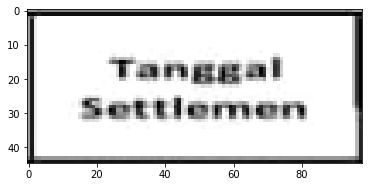

In [62]:
dfs = []
rho=0.01
threshold=30
min_line_length=50
max_line_gap=2

def update_y1(iy, x1_val, y1_val, hlines, tolerance=4):
    """ Find the previous horizontal line that has equal/smaller x1_val (unless it is the first line)
    
    For example, cell (1, 0) should have the same value as cell (0, 0) since they are merged.
    """
    iy2 = iy
#     print("iy2:", iy2, "compare",x1_val,"with",hlines[iy2, 0])
    while iy2 > 0 and (x1_val - hlines[iy2, 0]) < -tolerance:
        iy2 -= 1   
#         print("iy2:", iy2, "compare",x1_val,"with",hlines[iy2, 0])
    if iy2 >= 0:
        y1_val = hlines[iy2, 1]
    return y1_val

def get_y2(iy, y2, hlines):
    """ Find the next horizontal line that has the same x (unless it is the last line)
    
    For example, cell (0, 0) should be merged with cell (1, 0).
    """
    iy2, y2_val = iy, y2[iy]
    if hlines.shape[0]-1 > iy+1:
        iy2 = iy + 1
#         print("iy2:", iy2, "iy:", iy, "compare",hlines[iy2, 0],"with",hlines[iy, 0])
        while (hlines[iy2, 0] - hlines[iy, 0]) > 0.0001:
            y2_val = y2[iy2]
            iy2 += 1   
#             print("iy2:", iy2, "iy:", iy, "compare",hlines[iy2, 0],"with",hlines[iy, 0])
    return y2_val


def extract_cells(img, hlines, vlines, offset=0, header_rows=1):
    """ Split a greyscale image into cell images, given vertical and horizontal lines.
    """
    vlines = np.array(vlines)
    hlines = np.array(hlines)

    x1 = vlines[:-1, 0]
    y1 = hlines[:-1, 1]
    
    x2 = vlines[1:, 0]
    y2 = hlines[1:, 1]
    
    images = np.zeros((y1.shape[0],
                       x1.shape[0]), dtype='object')

#     print(vlines)
#     print(hlines)
#     print(x1)
#     print(x2)
#     print(y1)
#     print(y2)

    # Unfortunately, we cannot use vectorization to find all x2 and y2,
    # because some cells might be merged. Hence, resort to looping through
    # the cells and find next line that has the same x or y.

    # Perform cropping
    for ix, x1_val in enumerate(x1):
        x2_val = x2[ix]
        for iy, y1_val in enumerate(y1):
            
            y1_val = update_y1(iy, x1_val, y1_val, hlines, tolerance=4)
            y2_val = get_y2(iy, y2, hlines)
#             print("Set images [{}, {}] with {}:{}, {}:{}".format(ix, iy, y1_val, y2_val, x1_val, x2_val))
            images[iy, ix] = img[y1_val:y2_val+offset, x1_val:x2_val+offset]
    return images
    
# Test
filename = "../test3.jpeg"
img = cv.imread(filename)
tables = find_tables(img)
rho=0.01
threshold=30
min_line_length=50
max_line_gap=1

for table in tables:
    img_copy = np.copy(table) #image to draw lines
    gray = cv.cvtColor(table, cv.COLOR_BGR2GRAY)

    canny = cv.Canny(gray, 100, 100)

    hlines, vlines, img_show = \
        find_lines(canny, img_copy=img_copy, rho=rho, threshold=threshold,
                   min_line_length=min_line_length, max_line_gap=max_line_gap,
                   func_h=custom_h, func_v=custom_v)
    cells = extract_cells(gray, hlines, vlines, offset=2, header_rows=2)
    show_img(cells[0,4])

In [61]:
cells.shape

(79, 10)


{'level': [1], 'page_num': [1], 'block_num': [0], 'par_num': [0], 'line_num': [0], 'word_num': [0], 'left': [0], 'top': [0], 'width': [72], 'height': [17], 'conf': ['-1'], 'text': ['']}


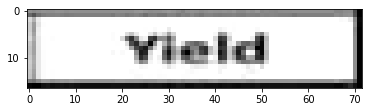

In [65]:
import pytesseract
import math
import os

def detect(cropped_frame, is_number = False):
    if (is_number):
        text = pytesseract.image_to_string(cropped_frame,
                                           config ='-c tessedit_char_whitelist=0123456789 --psm 10 --oem 2')
    else:
        text = pytesseract.image_to_string(cropped_frame, config='--psm 10')        
        
    return text

def crop_to_text(image):
    MAX_COLOR_VAL = 255
    BLOCK_SIZE = 15
    SUBTRACT_FROM_MEAN = -2

    img_bin = cv.adaptiveThreshold(
        ~image,
        MAX_COLOR_VAL,
        cv.ADAPTIVE_THRESH_MEAN_C,
        cv.THRESH_BINARY,
        BLOCK_SIZE,
        SUBTRACT_FROM_MEAN,
    )

    img_h, img_w = image.shape
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (int(img_w * 0.5), 1))
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, int(img_h * 0.7)))
    horizontal_lines = cv.morphologyEx(img_bin, cv.MORPH_OPEN, horizontal_kernel)
    vertical_lines = cv.morphologyEx(img_bin, cv.MORPH_OPEN, vertical_kernel)
    both = horizontal_lines + vertical_lines
    cleaned = img_bin - both

    # Get rid of little noise.
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    opened = cv.morphologyEx(cleaned, cv.MORPH_OPEN, kernel)
    opened = cv.dilate(opened, kernel)

    contours, hierarchy = cv.findContours(opened, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv.boundingRect(c) for c in contours]
    NUM_PX_COMMA = 6
    MIN_CHAR_AREA = 5 * 9
    char_sized_bounding_rects = [(x, y, w, h) for x, y, w, h in bounding_rects if w * h > MIN_CHAR_AREA]
    if char_sized_bounding_rects:
        minx, miny, maxx, maxy = math.inf, math.inf, 0, 0
        for x, y, w, h in char_sized_bounding_rects:
            minx = min(minx, x)
            miny = min(miny, y)
            maxx = max(maxx, x + w)
            maxy = max(maxy, y + h)
        x, y, w, h = minx, miny, maxx - minx, maxy - miny
        cropped = image[y:min(img_h, y+h+NUM_PX_COMMA), x:min(img_w, x+w)]
    else:
        # If we morphed out all of the text, assume an empty image.
        cropped = MAX_COLOR_VAL * np.ones(shape=(20, 100), dtype=np.uint8)
    bordered = cv.copyMakeBorder(cropped, 5, 5, 5, 5, cv.BORDER_CONSTANT, None, 255)
    return bordered
def ocr_image(image, config):
    return pytesseract.image_to_string(
        image,
        config=config
    )

# Test
filename = "../test3.jpeg"
img = cv.imread(filename)
tables = find_tables(img)
rho=0.01
threshold=30
min_line_length=50
max_line_gap=1

for table in tables:
    img_copy = np.copy(table) #image to draw lines
    gray = cv.cvtColor(table, cv.COLOR_BGR2GRAY)

    canny = cv.Canny(gray, 100, 100)

    hlines, vlines, img_show = \
        find_lines(canny, img_copy=img_copy, rho=rho, threshold=threshold,
                   min_line_length=min_line_length, max_line_gap=max_line_gap,
                   func_h=custom_h, func_v=custom_v)
    cells = extract_cells(gray, hlines, vlines, offset=2, header_rows=2)
#     cell = cells[28,4]
    cell = cells[1,8]
    show_img(cell)
    result = crop_to_text(cell)
    
    
    tessdata_dir = os.path.join(".","tessdata")
    tess_args = ["--psm", "7", "--tessdata-dir", tessdata_dir]
    txt = ocr_image(cell, " ".join(tess_args))
    
    show_img(cell)
    print(txt)
    
    data = pytesseract.image_to_data(
        cell,
        config=" ".join(tess_args),
        output_type='dict'
    )
    print(data)

In [198]:
import sys
import table_ocr
sys.modules["table_ocr"].__file__

'/home/jay/.virtualenvs/default/lib/python3.9/site-packages/table_ocr/__init__.py'